In [1]:
# import modules
import os
import datetime as dt
from collections import Counter
import pandas as pd
import numpy as np
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import raw_data_process

# Load CSV Raw Data

In [ ]:
# dir and file path
RAW_FLOW_DIRECTORY = 'raw_data/flow'
PARQUET_FLOW_DIRECTORY = 'data/flow'
RAW_STATION_DIRECTORY = 'raw_data/station_meta'
PARQUET_STATION_DIRECTORY = 'data/station_meta'
RAW_PM_DIRECTORY = 'raw_data/pm'
PARQUET_PM_DIRECTORY = 'data/pm'

In [ ]:
# read raw csv data and save them as parquet
flow_dict = raw_data_process.raw_flow_to_parquet(RAW_FLOW_DIRECTORY, PARQUET_FLOW_DIRECTORY)
sdf = raw_data_process.tweak_station_meta(RAW_STATION_DIRECTORY, 2019, flow_dict['d12_20191008'], PARQUET_STATION_DIRECTORY)
pmdf = raw_data_process.tweak_pm_df(RAW_PM_DIRECTORY, PARQUET_PM_DIRECTORY)

# Load Parquet Data

- `raw_flow_dict`
- `sdf`
- `pmdf`

In [2]:
raw_flow, sdf, pmdf = raw_data_process.load_parquet_data('data')

## View Imported Data

In [ ]:
sdf.head(3)

In [ ]:
pmdf.head(3)

# Select Desired Route, Direction, and Lane Type

- Sort by `timestamp` and `station`

### Route 405-N-ML as Test Case

- Check shape
- Check if each station is unique


In [ ]:
raw_flow['d12_20191008'].shape

In [3]:
flow_405NML = {}
flow_405NML_non_int = {}
for key, df in raw_flow.items():
    flow_405NML[key] = raw_data_process.select_route(df, 405, 'N', 'ML')
    flow_405NML[key] = raw_data_process.process_flow(flow_405NML[key])
    flow_405NML_non_int[key], flow_405NML[key] = raw_data_process.flow_interpolation(flow_405NML[key], pmdf, 12, 405)

In [14]:
flow_405NML_non_int['d12_20191008']

,freeway_num,district,abs_pm,latitude,longitude,0000,0005,0010,0015,0020,...,2310,2315,2320,2325,2330,2335,2340,2345,2350,2355
0,405,12,0.23,33.643991,-117.735577,14.0,0.0,0.0,0.0,0.0,...,97.0,75.0,66.0,17.0,0.0,0.0,0.0,72.0,0.0,0.0
1,405,12,0.30,33.644606,-117.736518,14.0,0.0,0.0,0.0,0.0,...,97.0,75.0,66.0,17.0,0.0,0.0,0.0,72.0,0.0,0.0
2,405,12,0.40,33.645283,-117.738040,14.0,0.0,0.0,0.0,0.0,...,97.0,75.0,66.0,17.0,0.0,0.0,0.0,72.0,0.0,0.0
3,405,12,0.50,33.645762,-117.739672,37.0,43.0,45.0,56.0,42.0,...,97.0,75.0,66.0,55.0,56.0,67.0,73.0,72.0,51.0,37.0
4,405,12,0.60,33.646240,-117.741304,37.0,43.0,45.0,56.0,42.0,...,97.0,75.0,66.0,55.0,56.0,67.0,73.0,72.0,51.0,37.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
236,405,12,23.80,33.780904,-118.090590,65.0,70.0,76.0,68.0,60.0,...,137.0,125.0,138.0,97.0,109.0,87.0,98.0,88.0,94.0,94.0
237,405,12,23.90,33.782308,-118.090975,65.0,70.0,76.0,68.0,60.0,...,137.0,125.0,138.0,97.0,109.0,87.0,98.0,88.0,94.0,94.0
238,405,12,24.00,33.783682,-118.091464,65.0,70.0,76.0,68.0,60.0,...,137.0,125.0,138.0,97.0,109.0,87.0,98.0,88.0,94.0,94.0
239,405,12,24.10,33.785060,-118.092377,65.0,70.0,76.0,68.0,60.0,...,137.0,125.0,138.0,97.0,109.0,87.0,98.0,88.0,94.0,94.0


In [32]:
flow_405NML_non_int['d12_20191008'].query('abs_pm>0.3 & abs_pm<0.6')[['abs_pm', '0000', '0005', '0010']]

,abs_pm,0000,0005,0010
2,0.4,14.0,0.0,0.0
3,0.5,37.0,43.0,45.0


In [53]:
# for row 1
time_col_names = [
        f"{hour:02d}{minute:02d}" for hour in range(0, 24) for minute in range(0, 60, 5)
    ]
cols_name = ['abs_pm'] + time_col_names
pd.concat([flow_405NML['d12_20191008'][cols_name].iloc[1, :], flow_405NML_non_int['d12_20191008'][cols_name].iloc[1, :]], axis=1).T


,abs_pm,0000,0005,0010,0015,0020,0025,0030,0035,0040,...,2310,2315,2320,2325,2330,2335,2340,2345,2350,2355
1,0.3,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,97.0,75.0,66.0,17.0,0.0,0.0,0.0,72.0,0.0,0.0
1,0.3,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,...,97.0,75.0,66.0,17.0,0.0,0.0,0.0,72.0,0.0,0.0


In [ ]:
import matplotlib.pyplot as plt

time_col_names = [
        f"{hour:02d}{minute:02d}" for hour in range(0, 24) for minute in range(0, 60, 5)
    ]
cols_name = ['abs_pm'] + time_col_names
flow_df = pd.concat([flow_405NML['d12_20191008'][cols_name].iloc[1, :], flow_405NML_non_int['d12_20191008'][cols_name].iloc[1, :]], axis=1).T

plt.figure(figsize=(10, 6))

# Loop over each segment
for i in range(len(df_d['PM']) - 1):
    x = df_d['PM'].iloc[i:i+2]
    y = df_d['traffic_flow'].iloc[i:i+2]

    # If the current point is interpolated, the line to the next point is red, else blue
    color = 'red' if df_d['interpolated'].iloc[i] else 'blue'
    plt.plot(x, y, color=color)

plt.xlabel('PM')
plt.ylabel('traffic_flow')
plt.title('Traffic flow vs PM')
plt.show()

## Assign Null values to traffic flow

- Assigns NaN to the 'total_flow' column where the 'pct_observed' is less than 70

### Check NaN Values

- Pivot the raw df with index=station, columns=timestamp, values=total_flow
- Drop the row if the row includes more than 50% of NaN

### Naming

- {route_type}\_{route_num}{direction}\_{lane_type}

## Merge, fillna, Interpolation

Merge ready dfs:
- Flow: I_405N_ML_merged
- Postmile: I_405N_pm

In [ ]:
def plot_station_flow(interpolated_df, uninterpolated_df, num_intervals):
     if num_intervals not in [3, 6, 9, 12]:
          raise ValueError("'num_intervals' must be either 3, 6, 9, or 12.")

     # TODO: only slice the first row

     fig, ax = plt.subplots(figsize=(20, 6))

     # plot interpolated flow
     time_of_day = interpolated_df.columns[1:-3]
     interpolated_flow = interpolated_df.iloc[0, 1:-3]
     ax.plot(time_of_day, interpolated_flow)

     # plot uninterpolated flow
     uninterpolated_flow = uninterpolated_df.iloc[0, 1:-3]
     missing_flow = uninterpolated_flow[pd.isna(uninterpolated_flow)]
     missing_flow_x = missing_flow.index
     missing_flow_y = [interpolated_flow[time] for time in missing_flow_x]
     ax.plot(missing_flow_x, missing_flow_y, 'ro', label='Interpolated Flow')

     # only show every 15 minutes
     xtick_position = range(0, len(time_of_day), num_intervals)
     xtick_labels = time_of_day[::num_intervals]

     # set ax xticks
     ax.set_xticks(xtick_position)
     ax.set_xticklabels(xtick_labels, rotation=90)

     # set x-axis labels
     ax.set_xlabel('Time')

     # set y-axis labels
     ax.set_ylabel('Total Flow')

     # add a legend
     ax.legend()

     # show the plot
     plt.show()



In [ ]:
plot_station_flow(df_405N_ML_interpolated, df_405N_ML_merged, 12)

In [ ]:
df_a = pd.DataFrame({'PM': [0, 0.1, 0.2, 0.3, 0.4, 0.5]})
df_c = pd.DataFrame({'PM': [0.03, 0.26, 0.35, 0.4, 0.49, 0.65], 'traffic_flow': [100, 200, 300, 400, np.nan, 600]})

# Create a boolean column indicating if the value was interpolated
df_c['interpolated'] = df_c['traffic_flow'].isna()

# Interpolate missing traffic_flow values in df_c
df_c['traffic_flow'] = df_c['traffic_flow'].interpolate()

# Create interval bins
bins = df_a['PM'].tolist() + [np.inf]

# Assign each PM in df_c to an interval in df_a
df_c['PM_range'] = pd.cut(df_c['PM'], bins=bins)

# Group by PM_range and calculate mean traffic_flow and maximum interpolated
traffic_flow_mean = df_c.groupby('PM_range').agg({'traffic_flow': 'mean', 'interpolated': 'max'}).reset_index()

traffic_flow_mean['PM'] = traffic_flow_mean['PM_range'].apply(lambda x: x.left)

# Merge the average traffic_flow and interpolated to df_a
df_final = pd.merge(df_a, traffic_flow_mean, on='PM', how='left')

# Clean up the final dataframe
df_final = df_final.drop(columns='PM_range')
df_final


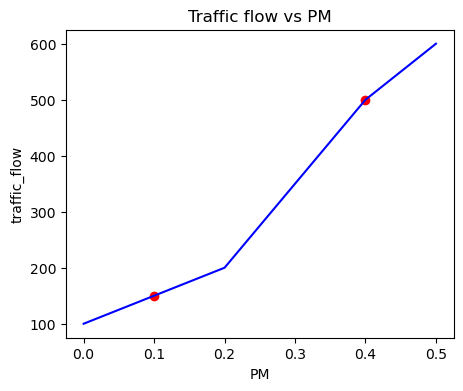

In [13]:
import matplotlib.pyplot as plt

df_d = pd.DataFrame({'PM': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                     'traffic_flow': [100, 150, 200, 350, 500, 600],
                     'interpolated': [False, True, False, False, True, False]})

plt.figure(figsize=(5, 4))
# Plot all points with a line
plt.plot(df_d['PM'], df_d['traffic_flow'], color='blue')

# Overplot the interpolated points with red color
plt.scatter(df_d[df_d['interpolated']]['PM'],
            df_d[df_d['interpolated']]['traffic_flow'],
            color='red')

plt.xlabel('PM')
plt.ylabel('traffic_flow')
plt.title('Traffic flow vs PM')
plt.show()

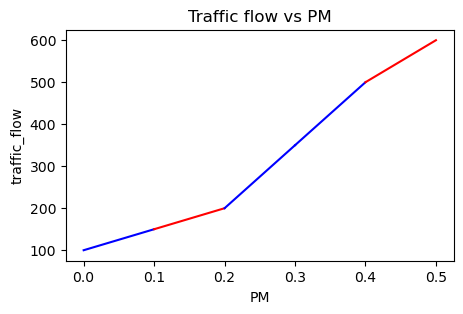

In [12]:
import matplotlib.pyplot as plt

df_d = pd.DataFrame({'PM': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
                     'traffic_flow': [100, 150, 200, 350, 500, 600],
                     'interpolated': [False, True, False, False, True, False]})

plt.figure(figsize=(5, 3))

# Loop over each segment
for i in range(len(df_d['PM']) - 1):
    x = df_d['PM'].iloc[i:i+2]
    y = df_d['traffic_flow'].iloc[i:i+2]

    # If the current point is interpolated, the line to the next point is red, else blue
    color = 'red' if df_d['interpolated'].iloc[i] else 'blue'
    plt.plot(x, y, color=color)

plt.xlabel('PM')
plt.ylabel('traffic_flow')
plt.title('Traffic flow vs PM')
plt.show()